<a href="https://colab.research.google.com/github/Shrivastav-Gaurav/GenAI-ML-Notebook/blob/main/MS_Course_Gen_AI_Lesson_11_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# --- Step 1: Mount Google Drive so we can read API key file ---
from google.colab import drive
drive.mount('/content/drive')
# After this step, all your Drive files are available under /content/drive/MyDrive/

# --- Step 2: Read the OpenAI API key from a text file in Drive ---
# Make sure you have created a file "OpenAI_key.txt" inside your Google Drive root (MyDrive).
# The file should contain your API key as a single line, no quotes.
with open('/content/drive/MyDrive/OpenAI_key.txt', 'r') as f:
    api_key = f.read().strip()  # strip() removes any accidental spaces/newlines

# --- Step 3: Set the key for OpenAI client ---
import os
os.environ["OPENAI_API_KEY"] = api_key

# --- Step 4: Student descriptions for extraction task ---
student_1_description = (
    "Emily Johnson is a sophomore majoring in computer science at Duke University. "
    "She has a 3.7 GPA. Emily is an active member of the university's Chess Club and Debate Team. "
    "She hopes to pursue a career in software engineering after graduating."
)

student_2_description = (
    "Michael Lee is a sophomore majoring in computer science at Stanford University. "
    "He has a 3.8 GPA. Michael is known for his programming skills and is an active member "
    "of the university's Robotics Club. He hopes to pursue a career in artificial intelligence "
    "after finishing his studies."
)

# --- Step 5: Create prompts for extracting structured data from text ---
prompt1 = f'''
Please extract the following information from the given text and return it as a JSON object:

name
major
school
grades
club

This is the body of text to extract the information from:
{student_1_description}
'''

prompt2 = f'''
Please extract the following information from the given text and return it as a JSON object:

name
major
school
grades
club

This is the body of text to extract the information from:
{student_2_description}
'''

# --- Step 6: Import libraries and create an OpenAI client ---
import json
from openai import OpenAI

client = OpenAI()  # This will automatically use the API key from OPENAI_API_KEY env variable

deployment = "gpt-3.5-turbo"  # Model selection




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# --- Step 7: Send first request to extract JSON from student_1_description ---
openai_response1 = client.chat.completions.create(
    model=deployment,
    messages=[{'role': 'user', 'content': prompt1}]
)
print("Raw GPT output (student 1):", openai_response1.choices[0].message.content)



Raw GPT output (student 1): {
  "name": "Emily Johnson",
  "major": "computer science",
  "school": "Duke University",
  "grades": "3.7 GPA",
  "club": ["Chess Club", "Debate Team"]
}


In [5]:
# --- Step 8: Send second request for student_2_description ---
openai_response2 = client.chat.completions.create(
    model=deployment,
    messages=[{'role': 'user', 'content': prompt2}]
)
print("Raw GPT output (student 2):", openai_response2.choices[0].message.content)



Raw GPT output (student 2): {
  "name": "Michael Lee",
  "major": "computer science",
  "school": "Stanford University",
  "grades": 3.8,
  "club": "Robotics Club"
}


In [6]:
# --- Step 9: Parse GPT responses into Python dictionaries ---
json_response1 = json.loads(openai_response1.choices[0].message.content)
print("Parsed JSON (student 1):", json_response1)

json_response2 = json.loads(openai_response2.choices[0].message.content)
print("Parsed JSON (student 2):", json_response2)

Parsed JSON (student 1): {'name': 'Emily Johnson', 'major': 'computer science', 'school': 'Duke University', 'grades': '3.7 GPA', 'club': ['Chess Club', 'Debate Team']}
Parsed JSON (student 2): {'name': 'Michael Lee', 'major': 'computer science', 'school': 'Stanford University', 'grades': 3.8, 'club': 'Robotics Club'}


In [12]:
# --- Step 10: Prepare a message for function-calling example ---
messages = [
    {"role": "user", "content": "Find me a good course for a beginner student to learn Azure."}
]

# --- Step 11: Define available functions for GPT to call ---
myfunctions = [
    {
        "name": "search_courses",
        "description": "Retrieves courses from the search index based on the parameters provided",
        "parameters": {
            "type": "object",
            "properties": {
                "role": {
                    "type": "string",
                    "description": "The role of the learner (i.e. developer, data scientist, student, etc.)"
                },
                "product": {
                    "type": "string",
                    "description": "The product that the lesson is covering (i.e. Azure, Power BI, etc.)"
                },
                "level": {
                    "type": "string",
                    "description": "The level of experience the learner has prior to taking the course (i.e. beginner, intermediate, advanced)"
                }
            },
            "required": ["role"]
        }
    }
]

In [13]:
# --- Step 12: Ask GPT with function-calling enabled ---
response = client.chat.completions.create(
    model=deployment,
    messages=messages,
    functions=myfunctions,
    function_call="auto"  # let GPT decide whether to call a function
)

print("Function calling raw GPT output:", response.choices[0].message)

response_message = response.choices[0].message

Function calling raw GPT output: ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=FunctionCall(arguments='{"role":"student","product":"Azure","level":"beginner"}', name='search_courses'), tool_calls=None)


In [9]:
# --- Step 13: Define the actual function in Python ---
import requests

def search_courses(role, product, level):
    """Calls Microsoft Learn API to retrieve courses based on given parameters."""
    url = "https://learn.microsoft.com/api/catalog/"
    params = {
        "role": role,
        "product": product,
        "level": level
    }
    response = requests.get(url, params=params)
    modules = response.json()["modules"]
    results = []
    for module in modules[:5]:  # limit to top 5 results
        title = module["title"]
        url = module["url"]
        results.append({"title": title, "url": url})
    return str(results)

In [10]:
# --- Step 14: If GPT suggested a function call, execute it ---
if response_message.function_call.name:
    print("Recommended Function call:", response_message.function_call.name)
    function_name = response_message.function_call.name
    available_functions = {"search_courses": search_courses}
    function_to_call = available_functions[function_name]
    function_args = json.loads(response_message.function_call.arguments)
    function_response = function_to_call(**function_args)

    print("Output of function call:", function_response)

    # Add GPT's function call and our function's output into messages for next request
    messages.append({
        "role": response_message.role,
        "function_call": {
            "name": function_name,
            "arguments": response_message.function_call.arguments,
        },
        "content": None
    })
    messages.append({
        "role": "function",
        "name": function_name,
        "content": function_response,
    })


Recommended Function call: search_courses
Output of function call: [{'title': 'Describe concepts of cryptography', 'url': 'https://learn.microsoft.com/en-us/training/modules/describe-concepts-of-cryptography/?WT.mc_id=api_CatalogApi'}, {'title': 'Introduction to audio classification with TensorFlow', 'url': 'https://learn.microsoft.com/en-us/training/modules/intro-audio-classification-tensorflow/?WT.mc_id=api_CatalogApi'}, {'title': 'Design a Performant Data Model in Azure SQL Database with Visual Studio Code', 'url': 'https://learn.microsoft.com/en-us/training/modules/design-a-data-model-with-ads/?WT.mc_id=api_CatalogApi'}, {'title': 'Get started with speech in Azure', 'url': 'https://learn.microsoft.com/en-us/training/modules/recognize-synthesize-speech/?WT.mc_id=api_CatalogApi'}, {'title': 'Host a web application with Azure App Service', 'url': 'https://learn.microsoft.com/en-us/training/modules/host-a-web-app-with-azure-app-service/?WT.mc_id=api_CatalogApi'}]


In [14]:
# --- Step 15: Send a follow-up request to GPT so it can use the function results ---
print("Messages in next request:", messages)

second_response = client.chat.completions.create(
    messages=messages,
    model=deployment,
    function_call="auto",
    functions=myfunctions,
    temperature=0
)
print("Final GPT response:", second_response.choices[0].message)

Messages in next request: [{'role': 'user', 'content': 'Find me a good course for a beginner student to learn Azure.'}]
Final GPT response: ChatCompletionMessage(content=None, refusal=None, role='assistant', annotations=[], audio=None, function_call=FunctionCall(arguments='{"role":"student","product":"Azure","level":"beginner"}', name='search_courses'), tool_calls=None)


Image Courtsey: Microsoft Gen AI for begeninners course

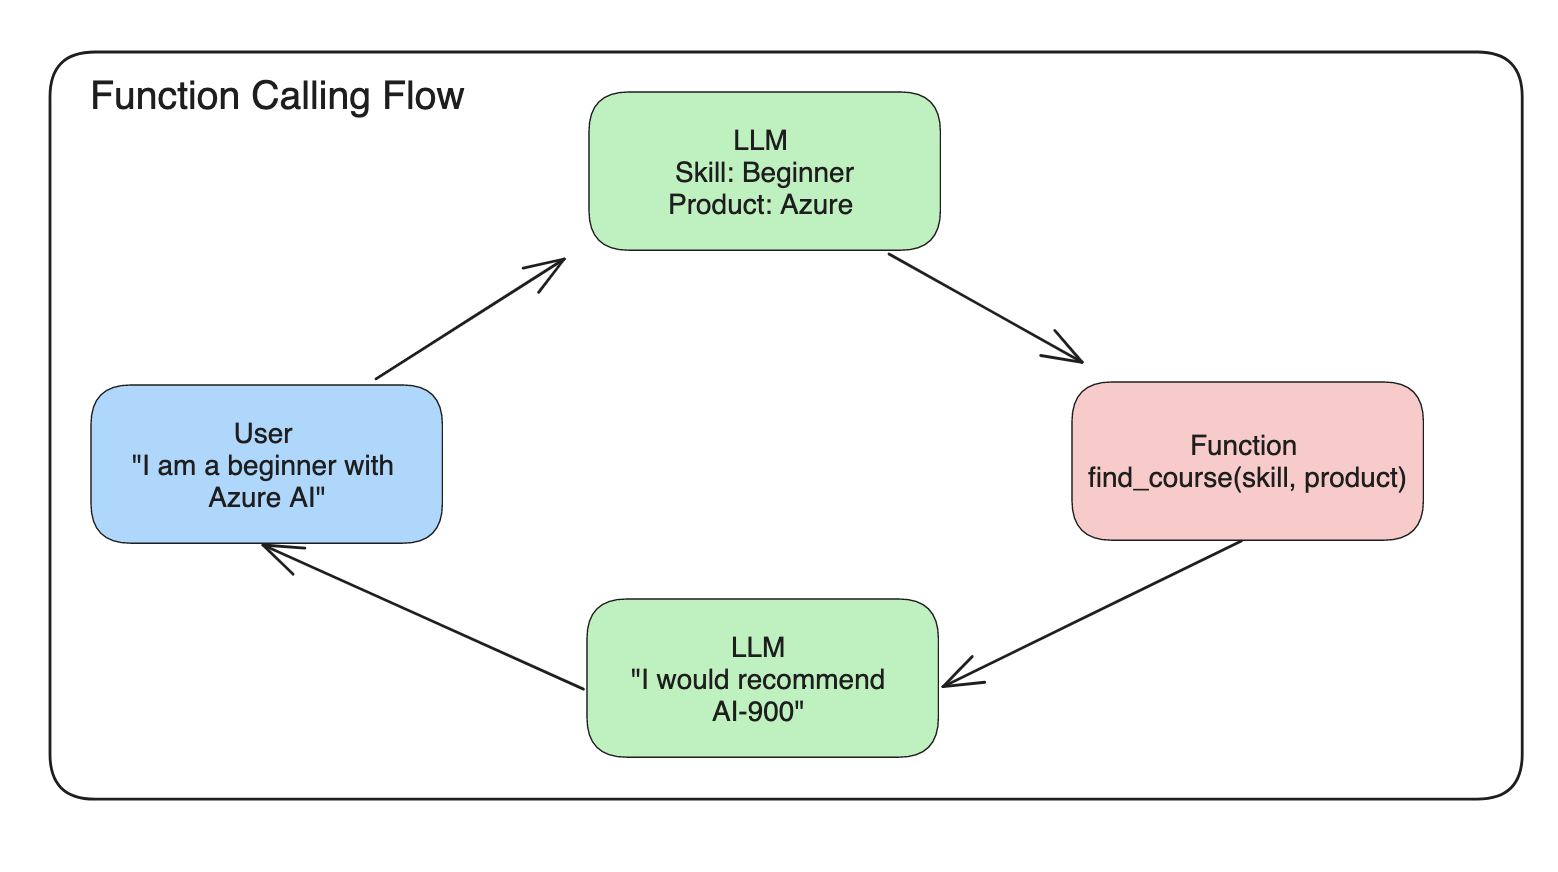

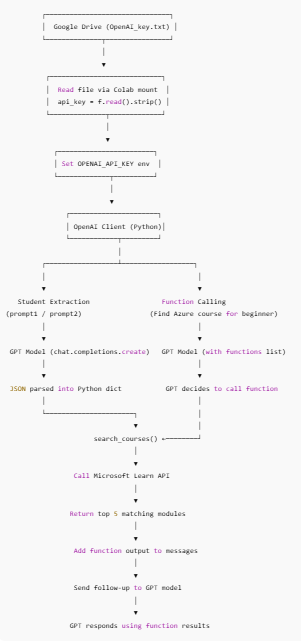

CONCEPTUAL FLOW                              | CODE SNIPPET
---------------------------------------------|----------------------------------------
1. Mount Google Drive                        | drive.mount('/content/drive')
   ↓                                          |
2. Read API key from file                     | with open('/content/drive/MyDrive/OpenAI_key.txt','r') as f:
   ↓                                          |     api_key = f.read().strip()
3. Store API key in env var                   | os.environ["OPENAI_API_KEY"] = api_key
   ↓                                          |
4. Create OpenAI client                       | client = OpenAI()
   ↓                                          |
5. Send student_1 prompt to GPT (no func)     | openai_response1 = client.chat.completions.create(
   ↓                                          |     model=deployment, messages=[{'role':'user','content':prompt1}]
6. Send student_2 prompt to GPT (no func)     | openai_response2 = client.chat.completions.create(
   ↓                                          |     model=deployment, messages=[{'role':'user','content':prompt2}]
7. Parse GPT JSON outputs                     | json_response1 = json.loads(openai_response1.choices[0].message.content)
   ↓                                          | json_response2 = json.loads(openai_response2.choices[0].message.content)
8. Create new user message needing search     | messages=[{"role":"user","content":"Find me a good course..."}]
   ↓                                          |
9. Define available GPT functions list        | functions=[{ "name":"search_courses", "description":"...", "parameters":{...}}]
   ↓                                          |
10. Ask GPT with functions enabled            | response = client.chat.completions.create(
    (GPT decides whether to call a function)  |     model=deployment, messages=messages, functions=functions, function_call="auto")
   ↓                                          |
11. GPT returns a function_call intent        | response_message = response.choices[0].message
    (name + arguments)                        | if response_message.function_call.name:
   ↓                                          |
12. Match GPT's function_call to Python func  | available_functions = {"search_courses": search_courses}
   ↓                                          | function_to_call = available_functions[function_name]
13. Execute real search_courses()             | function_response = function_to_call(**function_args)
    (calls Microsoft Learn API)               |
   ↓                                          |
14. Append GPT's function call + output       | messages.append({...})   # function_call
    back into messages list                   | messages.append({...})   # function output
   ↓                                          |
15. Send messages + results back to GPT       | second_response = client.chat.completions.create(
    for final user-friendly answer             |     messages=messages, model=deployment, functions=functions, function_call="auto")
